# 构建卷积神经网络，对cifar10进行建模
加入dropout层和relu激活层

In [1]:
%matplotlib inline

import os
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10 
from keras.models import Sequential 
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


载入cifar10数据，32*32*3的RGB图片

cifar10数据集已经被划分成了50000个训练集，10000个测试集的形式

查看一下数据格式，训练集一共有6万张，大小是28*28,单通道灰度图，测试集是1000张。标签是列向量

In [2]:
x_train = np.load('../data/cifar10/x_train.npy')
y_train = np.load('../data/cifar10/y_train.npy')
x_test = np.load('../data/cifar10/x_test.npy')
y_test = np.load('../data/cifar10/y_test.npy')

In [3]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape) 

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


可视化

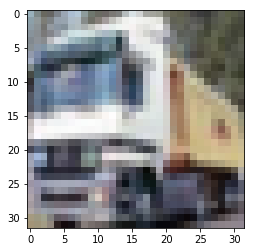

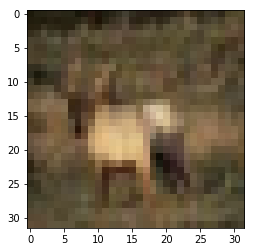

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_train[1])
plt.show()
plt.imshow(x_train[3])
plt.show()

归一化，将图像的像素归到0~1

In [5]:
x_train = x_train / 255
x_test = x_test / 255

将label也转换成One-hot标签，这里直接用keras的预置的一个函数 keras.utils.to_categorical

In [6]:
print(y_train[0: 10])# 查看原始标签 0~9

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [7]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(y_train[0:10])#查看转换完毕的标签

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


开始构建模型

In [8]:
num_classes = 10

model = Sequential()
#Layer 1 
model.add(Conv2D(48, kernel_size=(3,3),strides=(1,1), activation='relu', padding='same', input_shape=x_train.shape[1:] ) )
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Layer 2
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same') )
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Layer 3
model.add(Conv2D(192, kernel_size=(3,3), activation='relu', padding='same') )

#Layer 4
model.add(Conv2D(192, kernel_size=(3,3), activation='relu', padding='same') )
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Layer 5
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same') )
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())

#Layer 6
model.add(Dense(4096))

#Layer 7 
model.add(Dense(4096))

#Prediction
model.add(Dense(10, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model.summary()#这一句用来输出网络结构

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       55424     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 192)         221376    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 192)         331968    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 192)         0         
__________

配置模型，主要包括 
loss：loss计算方法（损失函数）

optimizer：优化函数

metrics：指定哪些量需要在训练及测试中关注，一般都会写accuracy

In [10]:
# initiate SGD optimizer
sgd = SGD(lr=0.001, momentum=0.9)

model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [11]:
# 自定义callback类
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        
        plt.figure()
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()

history = LossHistory()

In [12]:
model.fit(x_train,y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(x_test,y_test),
          callbacks=[history])

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 301s 6ms/step - loss: 2.1941 - acc: 0.1764 - val_loss: 1.9727 - val_acc: 0.2806
Epoch 2/10
50000/50000 [==============================] - 300s 6ms/step - loss: 1.8345 - acc: 0.3331 - val_loss: 1.6819 - val_acc: 0.3830
Epoch 3/10
50000/50000 [==============================] - 300s 6ms/step - loss: 1.5782 - acc: 0.4238 - val_loss: 1.5580 - val_acc: 0.4438
Epoch 4/10
50000/50000 [==============================] - 300s 6ms/step - loss: 1.4303 - acc: 0.4849 - val_loss: 1.3692 - val_acc: 0.5014
Epoch 5/10
50000/50000 [==============================] - 300s 6ms/step - loss: 1.3069 - acc: 0.5319 - val_loss: 1.2905 - val_acc: 0.5413
Epoch 6/10
50000/50000 [==============================] - 300s 6ms/step - loss: 1.2092 - acc: 0.5710 - val_loss: 1.1713 - val_acc: 0.5867
Epoch 7/10
50000/50000 [==============================] - 300s 6ms/step - 

### 提问：为什么上面显示的是50000呢？

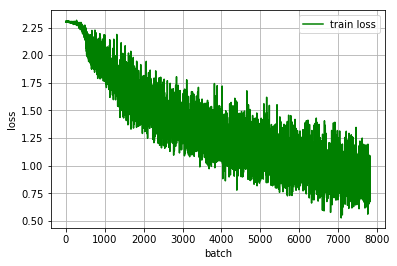

In [18]:
history.loss_plot('batch')

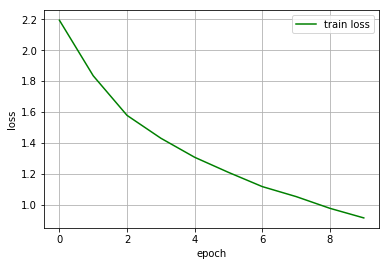

In [19]:
history.loss_plot('epoch')

In [20]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy', score[1])

10000/10000 [==============================] - 20s 2ms/step
Test loss: 0.9941089230537414
Test accuracy 0.651


In [21]:
score

[0.9941089230537414, 0.651]

## 计算准确与召回

As of Keras 2.0, precision and recall were removed from the master branch. You will have to implement them yourself.

In [22]:
import numpy as np
from sklearn.metrics import classification_report

predicted = model.predict(x_test, verbose=1)

report = classification_report(np.argmax(y_test, axis=1), np.argmax(predicted, axis=1))
print(report)

10000/10000 [==============================] - 19s 2ms/step
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      1000
           1       0.73      0.84      0.78      1000
           2       0.57      0.54      0.55      1000
           3       0.53      0.34      0.41      1000
           4       0.62      0.56      0.59      1000
           5       0.53      0.58      0.56      1000
           6       0.71      0.76      0.74      1000
           7       0.59      0.80      0.68      1000
           8       0.90      0.62      0.73      1000
           9       0.75      0.69      0.72      1000

   micro avg       0.65      0.65      0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000

